In [55]:
import torch
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.draw import random_shapes
import cv2
import pandas as pd
import random

In [132]:
imgDim = 16

In [133]:
#Function to generate a dimxdim image of a random shape of a size between given bounds
def shape_gen(imgDim, minimum,maximum):
    x = random_shapes((dim, dim), max_shapes=1, multichannel=False, intensity_range=(0,0),min_size = minimum, max_size=maximum)[0]
    x = (-1*x+255)/255
    return(x)

In [135]:
#Create array of start images

images_seq = [shape_gen(imgDim,10,25) for i in range(1000)]
images_seq = np.array(images_seq)
images_seq = np.expand_dims(images_seq,1)

test_seq = [shape_gen(imgDim,10,25) for i in range(100)]
test_seq = np.array(test_seq)
test_seq = np.expand_dims(test_seq,1)

In [136]:
#For a given collection of start images with (n,1,k,k), with n images of dimension k by k. Trans_range is one-sided,
#so trans_range = 4 allows translations of 4 up or down, 4 left or right. same for rot_center, how much the center of 
#rotation can shift to one-side both up/down. rot_angle is maximum angle in DEGREES
def rand_trans(data, trans_range, rot_center, rot_angle): 
    n, row, col = data[:,0,:,:].shape
    Index = [random.randint(0,1) for i in range(n)] #randomly choose either translation or rotation
    
    def M_gen(i):
        if i == 0:
            hor = random.randint(-trans_range, trans_range)
            ver = random.randint(-trans_range, trans_range)
            x = np.float32([[1,0,hor],[0,1,ver]]) #create translation matrix
        else:
            center = (row/2+random.randint(-rot_center,rot_center),col/2+random.randint(-rot_center,rot_center))
            angle = random.uniform(0,rot_angle)
            x = cv2.getRotationMatrix2D(center,angle,1) #create rotation matrix
        return(x)
    
    Z = np.array([M_gen(i) for i in Index])
    
    return(Z)
    

In [137]:
M = rand_trans(images_seq, 2, 2, 45)
M2 = rand_trans(test_seq, 2, 2, 45)

In [138]:
#for a given collection of start images - "data" - and their associated transformations -"transform", one for each start image-
#will generate a movie sequence of the desired length. note "data" should be np.array of shape (n,1,k,k).
def image_gen(data, transform, movie_len, imgDim):
    X = data
    for j in range(movie_len-1):
        Y = np.array([cv2.warpAffine(X[i,j],M[i],(imgDim,imgDim)) for i in range(data.shape[0])])
        Y = np.expand_dims(Y,1) #add the second axis, which denotes time, to concatenate the images
        X = np.concatenate((X,Y),axis=1)
    
    X = X.reshape(X.shape[0],X.shape[1],X.shape[2]**2)
    return(X) #reshape so it's easier to work with

In [139]:
data = image_gen(images_seq, M, 10, imgDim)
test_raw = image_gen(test_seq, M2, 10, imgDim)

In [140]:
data.shape

(1000, 10, 256)

In [141]:
def multi_gen(test_seq, testSize, maxShapes):
    
    #Set up first array, then just loop by concatenating.
    
    test_data = test_seq[np.random.randint(0,test_seq.shape[0],maxShapes)] #choose random number of movie sequences
    test_data = np.sum(test_data,axis= 0) #sum them together
    test_data[test_data > 1] = 1 #cap images at 1
    test_data = np.expand_dims(test_data, axis = 0) #add back the extra first axis, which indexes every movie sequence
    
    for datum in range(1,testSize):
        subset = test_seq[np.random.randint(0,test_seq.shape[0],maxShapes)]
        subset = np.sum(subset,axis=0)
        subset[subset > 1] = 1
        subset = np.expand_dims(subset, axis = 0)
        test_data = np.concatenate((test_data,subset),axis=0)
    
    return(test_data)

In [142]:
test_set = multi_gen(test_raw, 100, 2)

In [143]:
test_set.shape

(100, 10, 256)

In [144]:
#Rationale: since movies of multiple objects, with overlap, will just be sum of two images with values capped at 255,
#want transforms to reflect this ceiling like behavior or else prediction might be bad. 
#Will use a smooth squashing function, tanh.

def squash(x):
    y = 1.3*np.tanh(x)
    return(y)

def squash_deriv(x):
    y = 1.3*(1-np.tanh(x)**2)
    return(y)

In [149]:
numTransforms = 15
trainSteps = 1000
batchSize = 20 #training 
sparsePen = 1
derivPen = .5
epsilon = .0001 #variance of normal desntiy in the smoothed bump function.
eta = .01 #learning rate of phi, the dictionary of transforms
eta2 = .05 #learning rate of beta, the transform coeff
eta3 = .1 #Learning rate of center
eta4 = .1 #Learning rate of radii
numInference = 50 #number of basis trans * length of movie sequence
betaStep = 10 #FOR TRAINED TRANSFORMS. mini cycle for beta
attStep = 5 #FOR TRAINED TRANSFORMS. mini cycle for center/radii

In [91]:
data_batch = data[np.random.randint(0,data.shape[0],batchSize)]
Input = data_batch[:,:9,:] #will predict next frame from these
Output = data_batch[:,1:10,:] #the frames to be predicted
dim = data_batch.shape[2]
phi = np.random.rand(dim, dim ,numTransforms)

In [92]:
beta = np.zeros((Input.shape[0],Input.shape[1],phi.shape[2]))

In [63]:
print("beta shape:" + str(beta.shape) + "phi shape:" + str(phi.shape) + "Input shape:" + str(Input.shape))

beta shape:(30, 9, 15)phi shape:(1024, 1024, 15)Input shape:(30, 9, 1024)


In [64]:
predictions = np.einsum('btk,ijk,btj -> bti', beta, phi, Input)

In [49]:
error = Output - squash(predictions)

In [50]:
error.shape

(30, 9, 1024)

In [54]:
check1 = timeDiff(beta)

In [55]:
check1.shape

(9, 1024, 15)

In [96]:
phi2 = learnTransform(Input, Output, phi, beta, eta, 20)

In [97]:
phi2.shape

(1024, 1024, 15)

In [146]:
#Training algorithm, image sequences with one shape. No need to infer center/radii yet.
def timeDiff(beta):
    #assuming beta has shape bkt, where k for trans, t for length, B for number of images (usually batch size)
    
    Zeroes = np.zeros((beta.shape[0],1,beta.shape[2]))
    timeDeriv = np.diff(beta, axis= 1)
    X = np.concatenate((Zeroes, timeDeriv), axis=1)
    Y = np.concatenate((timeDeriv,Zeroes), axis =1)
    Z = -1*np.sign(X)+np.sign(Y)
    
    return(Z)

def inferBeta(Input, Output, phi, sparsePen, derivPen, eta2, numInference):
    #Assume data has shape (B, T, n2), where number of images(usually batch size) , T is time, and n2 is n^2 for nxn image
    #phi is of shape (i,i',k) where i,i' denote image dim, k denotes transform, T is time, and B is batch
    #Input are first T-1 frames. Output are frames 2 to T. Infer i^th frame from previous.
    
    beta = np.zeros((Input.shape[0],Input.shape[1],phi.shape[2])) #initialize beta at 0. beta is shape btk
    
    for step in range(numInference):
        predictions = np.einsum('btk,ijk,btj -> bti', beta, phi, Input)
        error = Output - predictions
        dBeta = np.einsum('bti,ijk,btj -> btk', error, phi, Input) - sparsePen*np.sign(beta) - derivPen*timeDiff(beta)
        beta += eta2*dBeta
        
    return(beta)
    
def learnTransform(Input, Output, phi, beta, eta, batchSize, numInference):
    
    for step in range(numInference):
        predictions = np.einsum('btk,ijk,btj -> bti', beta, phi, Input)
        error = Output - predictions
        dPhi = np.einsum('bti, btj, btk -> ijk', error, Input, beta)
        phi += (eta/batchSize)*dPhi
    
    return(phi)

In [153]:
#Traning algo, image sequences with one shape.

def Training1(dataset, trainSteps, batchSize, sparsePen, derivPen, eta, eta2, numInference, numTransforms):
    
    #intialize phi
    dim = dataset.shape[2]
    phi = np.random.rand(dim, dim ,numTransforms) #n2 x n2 x 15
    
    #start training
    for trial in range(trainSteps):
        
        data_batch = dataset[np.random.randint(0,dataset.shape[0],batchSize)] #create random batch
        Input = data_batch[:,:9,:] #will predict next frame from these
        Output = data_batch[:,1:10,:] #the frames to be predicted
        
        #Find beta, fix, then optimize phi
        beta = inferBeta(Input, Output, phi, sparsePen, derivPen, eta2, numInference)
        phi = learnTransform(Input, Output, phi, beta, eta, batchSize, numInference)
        
        #renormalize by capping absolute value to 1
        phi = phi/(np.abs(phi).max(axis=(0,1),keepdims=True))
        
    
    return(phi)
    

In [154]:
learnedPhi = Training1(data, 1, 5, sparsePen, derivPen, eta, eta2, 1, numTransforms)
learnedPhi.shape

(256, 256, 15)

In [67]:
movie_seq = data[0]
movie_seq.shape
dim = int(np.sqrt(movie_seq.shape[1]))

In [68]:
Input = movie_seq[:(movie_seq.shape[0]-1),:]
Output = movie_seq[1:,:]
Input2 = Input.reshape((Input.shape[0],dim,dim)) #just reshape to make region of interest indices more natural
movie_length = Input2.shape[0]
numInference2 = 10 #this is arbitrary. want to update each of beta, c, r a little
beta = np.zeros((Input2.shape[0],phi.shape[2])) #initialize beta at 0. beta is shape tk. movie_seq first dim is t
center = (dim/2)*np.ones((2,Input2.shape[0],phi.shape[2])) #initialize centers at center of image. each center is 2-vector
radius2 = 17*np.ones((Input2.shape[0],phi.shape[2])) #initialize radius2 at 17, so start off region of interest as entire image

In [59]:
def normalMatrix(movie_length, dim, center, radius2, epsilon):
    normal_matrix = np.empty((center.shape[2], movie_length, dim,dim)) #shape is ktdd, where k is number of transforms, t is time, d is dim of image
    
    for k in range(center.shape[2]):
        for t in range(movie_length):
            for i in range(dim):
                for j in range(dim):
                    normal_matrix[k,t,i,j] = (1/np.sqrt(2*np.pi*epsilon))*np.exp(-(radius2[t,k]-np.linalg.norm(np.array([i,j])-center[:,t,k])**2)**2/(2*epsilon**2))
    
    return(normal_matrix)

def center_ParDeriv(movie_length, dim, center, radius2, epsilon): #calculates partial deriv for center, where each entry is 2-vector
    normal_matrix = np.empty((center.shape[2], movie_length, dim,dim)) #shape is ktdd, where k is number of transforms, t is time, d is dim of image
    
    for k in range(center.shape[2]):
        for t in range(movie_length):
            for i in range(dim):
                for j in range(dim):
                    normal_matrix[k,t,i,j] = (1/np.sqrt(2*np.pi*epsilon))*np.exp(-(radius2[t,k]-np.linalg.norm(np.array([i,j])-center[:,t,k])**2)**2/(2*epsilon**2))
    
    distance_pd = np.empty((2,center.shape[2], movie_length, dim, dim)) #shape 2ktdd
    for i in range(dim):
        for j in range(dim):
            distance_pd[:,k,t,i,j] = 2*(np.array([i,j])-center[:,t,k])
            
    centerPD = np.multiply(distance_pd, normal_matrix)
    return(centerPD)

In [60]:
center2 = center_ParDeriv(movie_length, dim, center, radius2, epsilon).reshape((2,center.shape[2],movie_length, Input.shape[1]))
center2.shape

(2, 15, 9, 1024)

In [70]:
def localImage(Input2, movie_length, dim, center, radius2, epsilon):
    local_matrix = np.empty((center.shape[2], movie_length, dim,dim)) #shape is ktdd, where k is number of transforms, t is time, d is dim of image
    
    for k in range(center.shape[2]):
        for t in range(movie_length):
            for i in range(dim):
                for j in range(dim):
                    local_matrix[k,t,i,j] = (np.linalg.norm(np.array([i,j])-center[:,t,k])**2)/radius2[t,k]
    local_matrix[local_matrix <= 1+ epsilon] = 1
    local_matrix[local_matrix > 1 + epsilon] = 0
    
    LocalInput2 = np.multiply(local_matrix, Input2)
    
    return(LocalInput2)

In [113]:
localImage(Input2, movie_length, dim, center, radius2, epsilon).shape

(15, 9, 32, 32)

In [71]:
def InferRadius2(Input2, center, Output, radius2, phi, beta, eta3, epsilon, attStep):
    
    for step in range(attStep):
    
        localimg = localImage(Input2, movie_length, dim, center, radius2, epsilon).reshape((center.shape[2],movie_length, Input.shape[1])) #calculate localized images and reshape
        
        predictions = np.einsum('tk,ijk,ktj -> ti', beta, phi, localimg)
        error = Output - squash(predictions)
        dTanh = squash_deriv(predictions)
        ParDeriv = np.multiply(normalMatrix(movie_length, dim, center, radius2, epsilon), Input2).reshape((center.shape[2],movie_length, Input.shape[1]))
        #ParDeriv: each entry of matrix, reshaped as vector, is derivative of localized image wrt radius2
        dR = np.einsum('ti, tk, ijk, tj, ktj -> tk', error, beta, phi, dTanh, ParDeriv)
        radius2 += eta3*dR
                                                                                                                      
                                                                                                                
    return(radius2)      

In [132]:
localimg = localImage(Input2, movie_length, dim, center, radius2, epsilon).reshape((center.shape[2],movie_length, Input.shape[1]))

In [121]:
localimg.shape

(15, 9, 1024)

In [63]:
newrad2 = InferRadius2(Input2, center, Output, radius2, phi, beta, eta3, epsilon, attStep)
newrad2.shape

(9, 15)

In [72]:
def InferCenter(Input2, center, Output, radius2, phi, beta, eta4, epsilon, attStep):
    
    for step in range(attStep):
    
        localimg = localImage(Input2, movie_length, dim, center, radius2, epsilon).reshape((center.shape[2],movie_length, Input.shape[1])) #calculate localized images and reshape
        
        predictions = np.einsum('tk,ijk,ktj -> ti', beta, phi, localimg)
        error = Output - squash(predictions)
        dTanh = squash_deriv(predictions)
        centerPD = center_ParDeriv(movie_length, dim, center, radius2, epsilon).reshape((2,center.shape[2],movie_length, Input.shape[1]))
        #ParDeriv: each entry of matrix, reshaped as vector, is derivative of localized image wrt radius2
        dC = np.einsum('ti, tk, ijk, cktj -> ctk', error, beta, phi, centerPD)
        center += eta4*dC
                                                                                                                      
                                                                                                                
    return(center)        

In [68]:
InferCenter(Input2, center, Output, radius2, phi, beta, eta4, epsilon, attStep).shape

(2, 9, 15)

In [46]:
InferBeta2(Input2, center, Output, radius2, phi ,beta, eta, epsilon, betaStep).shape

(9, 15)

In [73]:
def InferBeta2(Input2, center, Output, radius2, phi ,beta, eta, epsilon, betaStep):
    
    for step in range(betaStep):
        
        localimg = localImage(Input2, movie_length, dim, center, radius2, epsilon).reshape((center.shape[2],movie_length, Input.shape[1])) #calculate localized images and reshape
        
        predictions = np.einsum('tk,ijk,ktj -> ti', beta, phi, localimg)
        error = Output - squash(predictions)
        dTanh = squash_deriv(predictions)
        dBeta = np.einsum('ti,ijk, tj, ktj -> tk', error, phi, dTanh, localimg) - sparsePen*np.sign(np.expand_dims(beta,axis=0))[0,:,:] - derivPen*timeDiff(np.expand_dims(beta,axis=0))[0,:,:]
        #just a bit of reshaping magic above to make the functions work, since sparse/derivPen made for data with extra batch dim
        beta += eta2*dBeta
    
    return(beta)

In [20]:
def InferLocal(movie_seq, phi, sparsePen, derivPen, eta2, eta3, eta4, betaStep, attStep, numInference): 
    #now want to infer beta, center, and radii for a single movie sequence
    #***RADII ARE SQUARED, to make computing the derivative easier***
    #assume movie sequence is shape txn2, where t is length (movie_length) and n2 is product of dimensions of 2d image
    

    dim = np.sqrt(movie_seq.shape[1])
    Input = movie_seq[:(movie_seq.shape[0]-1)]
    Output = movie_seq[1:]
    Input2 = Input.reshape((Input.shape[0],dim,dim)) #just reshape to make region of interest indices more natural
    numInference2 = 10 #this is arbitrary. want to update each of beta, c, r a little
    movie_length = Input2.shape[0]
    
    beta = np.zeros((Input2.shape[0],phi.shape[2])) #initialize beta at 0. beta is shape tk. movie_seq first dim is t
    center = (dim/2)*np.ones((2,movie_length,phi.shape[2])) #shape 2tk (2 since center is 2-vector). initialize centers at center of image. each center is 2-vector
    radius2 = (17**2)*np.ones((movie_length,phi.shape[2])) # shape tk.initialize radius2 at 17^2, so start off region of interest as entire image
    
    for bigStep in range(numInference):
        beta = InferBeta2(Input2, center, Output, radius2, phi ,beta, eta, epsilon, betaStep)
        radius2 = InferRadius2(Input2, center, Output, radius2, phi, beta, eta3, epsilon, attStep)
        center = InferCenter(Input2, center, Output, radius2, phi, beta, eta4, epsilon)
    
    finalImg = localImage(Input2, movie_length, dim, center, radius2, epsilon).reshape((center.shape[2],movie_length, Input.shape[1]))
    final_predictions = np.einsum('tk,ijk,ktj -> ti', beta, phi, finalImg)
    
    fig = plt.figure(figsize = (20,6))
    for i in range(movie_length):
        for j in range(2):
            fig.add_subplot(2,movie_length,movie_length*j+i+1)
            if j == 0:
                plt.imshow(Output[i].reshape((32,32)),cmap = "Greys")
            else: 
                plt.imshow(final_predictions[i].reshape((32,32)),cmap="Greys")
    
    return((beta,radius2,InferCenter))


In [74]:
finalImg = localImage(Input2, movie_length, dim, center, radius2, epsilon).reshape((center.shape[2],movie_length, Input.shape[1]))
final_predictions = np.einsum('tk,ijk,ktj -> ti', beta, phi, finalImg)

In [ ]:
fig = plt.figure(figsize=(6,10))
for i in range(5):
    for j in range(2):
        fig.add_subplot(2,5,5*j+i+1)
        plt.imshow(new[17*j,i].reshape((32,32)),cmap = "Greys")

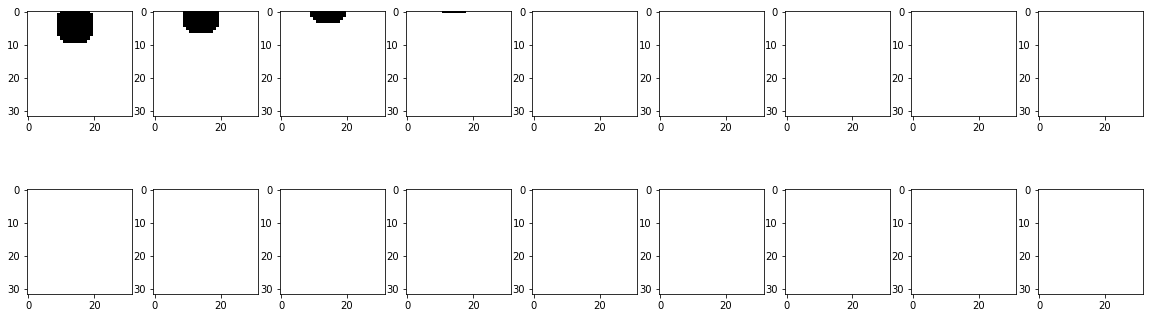

In [90]:
fig = plt.figure(figsize = (20,6))
for i in range(movie_length):
    for j in range(2):
        fig.add_subplot(2,movie_length,movie_length*j+i+1)
        if j == 0:
            plt.imshow(Output[i].reshape((32,32)),cmap = "Greys")
        else: 
            plt.imshow(final_predictions[i].reshape((32,32)),cmap="Greys")

In [41]:
center.shape

(2, 9, 15)

In [42]:
radius2.shape

(9, 15)

In [43]:
Input.shape

(9, 1024)